In [41]:
import torch
import torchvision
from torchvision import transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


model = torchvision.models.segmentation.deeplabv3_resnet101(weights='DeepLabV3_ResNet101_Weights.DEFAULT') 
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', weights='DeepLabV3_ResNet101_Weights.DEFAULT')
model.eval() #sets model in evaluation mode

filename = "testset/motorcycle.jpg"
input_image = Image.open(filename)
# input_image = input_image.resize([200, 200]) # for large images
input_image = input_image.convert("RGB")

W, H = input_image.size
print("input image dimensions:", H, W)

input image dimensions: 323 481


In [42]:
# The images have to be loaded in to a range of [0, 1] and then normalized using the following mean and std 
preprocess = transforms.Compose([ 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
display(input_tensor.shape)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model(adds 1 more dimension to tensor)

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)['out'][0]
output_predictions = output.argmax(0)  # To get the maximum prediction of each class
display(output_predictions.shape)


torch.Size([3, 323, 481])

torch.Size([323, 481])

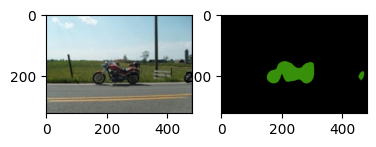

In [43]:
# create a color pallette, selecting a color for each class
def get_colors():
    palette = torch.tensor([np.random.randint(0, 256), np.random.randint(0, 256), np.random.randint(0, 256)])
    colors = torch.as_tensor([i for i in range(50)])[:, None] * palette
    colors = (colors % 255).numpy().astype("uint8")
    
    return colors

random_colors = get_colors()
colors = random_colors

# plot the semantic segmentation predictions of 21 classes in each color
deeplab_segmented_image = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
deeplab_segmented_image.putpalette(random_colors)

plt.subplot(1, 3, 1)
plt.imshow(input_image)
plt.subplot(1, 3, 2)
plt.imshow(deeplab_segmented_image)
plt.show()


In [44]:
# retrieving aspp layer features 
def get_aspp_features():
    aspp = torchvision.models.segmentation.deeplabv3.ASPP(in_channels=3, atrous_rates=[6, 12, 18])
    aspp.eval()

    aspp_features = aspp.forward(input_batch)
    return aspp_features.squeeze(0)

aspp_features = get_aspp_features()
#display(aspp_features)
display(aspp_features.shape)

torch.Size([256, 323, 481])

In [45]:
import cv2
import numpy as np


def draw_segmentation_map(outputs):
    labels = torch.argmax(outputs.squeeze(), dim=0).numpy()

    # Create Numpy arrays containing zeros.
    # Later to be used to fill them with respective red, green, and blue pixels.
    red_map = np.zeros_like(labels).astype(np.uint8)
    green_map = np.zeros_like(labels).astype(np.uint8)
    blue_map = np.zeros_like(labels).astype(np.uint8)

    for label_num in range(0, len(colors)):
        index = labels == label_num
        
        R, G, B = colors[label_num]

        red_map[index] = R
        green_map[index] = G
        blue_map[index] = B

    segmentation_map = np.stack([red_map, green_map, blue_map], axis=2)
    return segmentation_map


def image_overlay(image, segmented_image):
    alpha = 1   # transparency for the original image
    beta = 0.8  # transparency for the segmentation map
    gamma = 0   # scalar added to each sum

    image = np.array(image)
    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)
    
    cv2.addWeighted(image, alpha, segmented_image, beta, gamma, image)
    
    return image
     

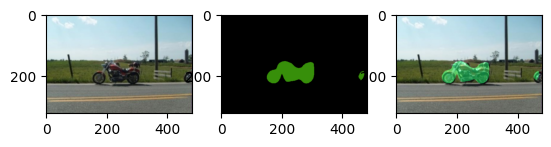

In [46]:
def perform_inference():
    # Get RGB segmentation map
    segmented_image = draw_segmentation_map(output)

    # Resize to original image size
    segmented_image = cv2.resize(segmented_image, input_image.size, cv2.INTER_LINEAR)
    overlayed_image = image_overlay(input_image, segmented_image)

    plt.subplot(1, 3, 1)
    plt.imshow(input_image)
    plt.subplot(1, 3, 2)
    plt.imshow(segmented_image)
    plt.subplot(1, 3, 3)
    plt.imshow(overlayed_image)
    
    return

perform_inference()

In [47]:
# Applying PCA to ASPP features
from sklearn.decomposition import PCA


def apply_pca_on_aspp(n_components):
    features = aspp_features.detach().numpy() # Convert to numpy array
    reshaped_aspp = features.reshape(256, features.shape[1]*features.shape[2])  # Reshape to [256, HEIGHT * WIDTH] (pca is applied to 2d data)
    pca = PCA(n_components=n_components)
    principalComponents = pca.fit_transform(reshaped_aspp.T).T # Transpose for the correct shape
    pca_features = principalComponents.reshape(n_components, *features.shape[1:]) 
    
    return pca_features

n_components = 2
pca_features = apply_pca_on_aspp(n_components)
display(pca_features.shape)


(2, 323, 481)

In [48]:
# Convert original image to LAB color space
def convert_lab():
    input = cv2.imread(filename)
    #input = cv2.resize(input, (200, 200))
    lab_image = cv2.cvtColor(input, cv2.COLOR_BGR2LAB)
    lab_image = np.transpose(lab_image, (2, 0, 1))
    
    return lab_image

lab_image = convert_lab()
display(lab_image.shape)

pca_lab_sum = np.concatenate((pca_features, lab_image), axis=0)
display(pca_lab_sum.shape)

(3, 323, 481)

(5, 323, 481)

In [49]:
#torch.set_printoptions(threshold=input_image.size[0] * input_image.size[1])
#print(output_predictions) 

# Check if any object was recognised
def has_objects():
    return (output_predictions != 0).any()


# Updates if no object was recognised
def update_no_objects_found(new_pca_lab_sum):
    w = 0.2
    new_pca_lab_sum[:2] = pca_lab_sum[:2] * w
    new_pca_lab_sum[2:] = pca_lab_sum[2:] * (1-w)


# Updates if at least one object was recognised
def update_objects_found(new_pca_lab_sum):
    w = 0.1
    for i in range(output_predictions.shape[0]):
        for j in range(output_predictions.shape[1]):
            if output_predictions[i][j] == 0:
                new_pca_lab_sum[:2, i , j] = pca_lab_sum[:2, i, j] * w
                new_pca_lab_sum[2:, i , j] = pca_lab_sum[2:, i, j] * (1-w)
            else:
                new_pca_lab_sum[:, i , j] = 0


print("Object found = ", has_objects())
new_pca_lab_sum = np.zeros(pca_lab_sum.shape)

if has_objects() == False:
    update_no_objects_found(new_pca_lab_sum)
else:
    update_objects_found(new_pca_lab_sum)

def print_updates():
    for i in range(new_pca_lab_sum.shape[0]):
        for j in range(new_pca_lab_sum.shape[1]):
            for k in range(new_pca_lab_sum.shape[2]):
                print(new_pca_lab_sum[i, j, k])

#print(new_pca_lab_sum) 

Object found =  tensor(True)


In [50]:
from collections import OrderedDict
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler


# Clustering
# Global k-means++
class Global_Kmeans_pp():
	def __init__(self, n_clusters=2, n_init=100, max_iter=300, tol=1e-4, verbose=1):
		self.n_clusters = n_clusters
		self.n_init = n_init
		self.max_iter = max_iter
		self.tol = tol
		self.verbose = verbose
		self.cluster_centers_ = OrderedDict()
		self.cluster_distance_space_ = OrderedDict()
		self.inertia_ = OrderedDict()
		self.labels_ = OrderedDict()

	def fit(self, X, y=None):
		kmeans = KMeans(n_clusters=1, init='random', n_init=1, tol=self.tol).fit(X)
		self.n_data = X.shape[0]
		self.cluster_centers_[1] = kmeans.cluster_centers_
		self.cluster_distance_space_[1] = kmeans.transform(X).min(axis=1)
		self.labels_[1] = kmeans.labels_
		self.inertia_[1] = kmeans.inertia_

		k = 1
		while True:
			if k < self.n_clusters:
				k += 1

				if 0 < self.verbose: print('Solving {:d}-means'.format(k))
				centroid_candidates, _ = self.__kmeans_pp(X, self.cluster_distance_space_[k-1])

				self.inertia_[k] = float('inf')
				for i, xi in enumerate(centroid_candidates): # TODO parallel
					current_centroids = np.vstack((self.cluster_centers_[k-1], xi))
					kmeans = KMeans(n_clusters=k, init=current_centroids, n_init=1, tol=self.tol)
					kmeans = kmeans.fit(X)

					if kmeans.inertia_ < self.inertia_[k]:
						self.cluster_centers_[k] = kmeans.cluster_centers_
						self.labels_[k] = kmeans.labels_
						self.inertia_[k] = kmeans.inertia_
						self.cluster_distance_space_[k] = kmeans.transform(X).min(axis=1)
			else:
				break

		return self

	def predict(self, X):
		return self.labels_, self.cluster_centers_, self.inertia_

	def transform(self, X):
		return self.cluster_distance_space_

	def __kmeans_pp(self, X, cluster_distance_space):
		cluster_distance_space = np.power(cluster_distance_space, 2).flatten()
		sum_distance = np.sum(cluster_distance_space)
		selection_prob = cluster_distance_space / sum_distance
		selected_indexes = np.random.choice(self.n_data, size=self.n_init, p=selection_prob, replace=False)
		kmeans_pp_selected_centroids = X[selected_indexes]
		return kmeans_pp_selected_centroids, selected_indexes

In [51]:
from diptest import diptest


# Unimodality Testing
def pca_split(X, ci, cj, alpha):
	pca = PCA(n_components = 1)
	projection = pca.fit_transform(X)
	projection = np.reshape(projection, (projection.shape[0],))
	dip, pval = diptest(projection)
	condition = pval < alpha
	return condition

def axis_split(X, c_i, c_j, alpha):
	w = c_j - c_i
	b = - np.dot(c_i, c_i)
	unnormalized_algebraic_distances_to_hyperplane = np.dot(X, w) + b
	dip, pval = diptest(unnormalized_algebraic_distances_to_hyperplane, boot_pval=False)
	condition = pval < alpha
	return condition

In [52]:
# Utilities
class UnionFind:
	def __init__(self, elements):
		self.size_ = len(elements) # number of trees
		self.data_structure_ = [i for i in range(self.size_)]
		self.sizes_ = [1 for i in range(self.size_)] # sizes of trees
		self.element_ = elements # index to element
		self.index_ = {element: index for index, element in enumerate(elements)} # element to index

	def union(self, element_1, element_2):
		root_1_index = self.index_[self.find(element_1)]
		root_2_index = self.index_[self.find(element_2)]

		size_1 = self.sizes_[root_1_index]
		size_2 = self.sizes_[root_2_index]
		union_size = size_1 + size_2

		# connecting the two trees
		if size_1 <= size_2:
			self.data_structure_[root_2_index] = root_1_index
		else:
			self.data_structure_[root_1_index] = root_2_index

		self.sizes_[root_1_index] = self.sizes_[root_2_index] = union_size
		self.size_ -= 1

	def find(self, element):
		index = self.index_[element]
		path_indices = []
		while self.data_structure_[index] != index:
			path_indices.append(index)
			index = self.data_structure_[index]
		root_index = index

		# shortening the tree
		for index in path_indices:
			self.data_structure_[index] = root_index

		return self.element_[root_index]

	def to_list(self):
		# turning all trees into stars
		for element in self.element_:
			self.find(element)

		list_of_lists = [[] for i in range(len(self.element_))]
		for index, element in enumerate(self.element_):
			list_of_lists[self.data_structure_[index]].append(element)
		return [_list for _list in list_of_lists if len(_list) > 0]
	
def cc_index(cc_list, node):
	for i, cc in enumerate(cc_list):
		if node in cc:
			return i
	return None

In [53]:
from scipy.sparse import lil_matrix
import networkx as nx


# UniForCE method

def overclustering(data, options):
	if np.isscalar(options['n_subclusters']):
		if options['algorithm'] == 'globalkmeans++':
			selected_model = Global_Kmeans_pp(n_clusters = options['n_subclusters'], n_init = 10).fit(data)
			return selected_model.labels_[selected_model.n_clusters], selected_model.cluster_centers_[selected_model.n_clusters]
		else:
			model = {
				'kmeans++': KMeans(n_clusters = options['n_subclusters'], n_init = 10)
			}
			selected_model = model[options['algorithm']].fit(data)
			return selected_model.labels_, selected_model.cluster_centers_
	else:
		if options['algorithm'] == 'globalkmeans++':
			selected_model = Global_Kmeans_pp(n_clusters = np.max(options['n_subclusters']), n_init = 10).fit(data)
			return selected_model.labels_, selected_model.cluster_centers_
		else:
			labels = {}
			cluster_centers = {}
			for K in options['n_subclusters']:
				model = {
					'kmeans++': KMeans(n_clusters = K, n_init = 10)
				}
				selected_model = model[options['algorithm']].fit(data)
				labels[K] = selected_model.labels_
				cluster_centers[K] = selected_model.cluster_centers_
			return labels, cluster_centers

def in_same_tree(uf, i, j):
	for this_set in uf.to_sets():
		if i in this_set and j in this_set:
			return True
	return False

def kruskal(data, subpredictions, subcluster_centers, options): # Kruskal's algorithm finds a minimum spanning forest of an undirected edge-weighted graph
	n_clusters = options['n_clusters']
	n_subclusters = options['n_subclusters']
	min_size = options['min_size']
	distribution = options['distribution']
	alpha = options['alpha']
	n_tests = options['n_tests']

	unimodality_test = {'default': axis_split, 'pca': pca_split}

	adjacency_matrix = lil_matrix(np.zeros([n_subclusters, n_subclusters], dtype=float))
	index_map = {tuple(subcluster_centers[i].tolist()): i for i in range(n_subclusters)}

	subcluster_sizes = np.unique(subpredictions, return_counts=True)[1]
	is_active = (subcluster_sizes >= min_size)
	active_subclusters = np.nonzero(is_active)[0]
	union_find = nx.utils.UnionFind(active_subclusters)

	edges = [(tuple(subcluster_centers[i].tolist()), tuple(subcluster_centers[j].tolist())) for i in active_subclusters for j in active_subclusters if i < j]

	# Sorting edges by their length in
	edges = sorted(edges, key = lambda edge: (edge[0][0] - edge[1][0])**2 + (edge[0][1] - edge[1][1])**2)

	# reassigning inactive subcluster samples
	is_inactive = (subcluster_sizes < min_size)
	inactive_subclusters = np.nonzero(is_inactive)[0]
	remaining_samples_indices = np.nonzero(np.isin(subpredictions, inactive_subclusters))[0]
	if remaining_samples_indices.shape[0] > 0:
		subpredictions[remaining_samples_indices] = active_subclusters[np.argmin(euclidean_distances(data[remaining_samples_indices], subcluster_centers[active_subclusters]), axis = 1)]

	# recalculating subcluster centers
	for j in range(n_subclusters):
		if is_active[j]:
			subcluster_centers[j, :] = np.average(data[np.where(subpredictions == j)[0]], axis = 0)

	for edge in edges:
		i = index_map[edge[0]]
		j = index_map[edge[1]]
		if not in_same_tree(union_find, i, j):

			# Samples of subclusters i and j
			samples_indexes_i = np.where(subpredictions==i)[0]
			samples_indexes_j = np.where(subpredictions==j)[0]
			samples_indexes = np.concatenate((samples_indexes_i, samples_indexes_j))
			X, y = data[samples_indexes], subpredictions[samples_indexes]

			# Sorting subclusters by sample size
			n_i = samples_indexes_i.shape[0]
			n_j = samples_indexes_j.shape[0]
			if n_j < n_i:
				temp = samples_indexes_i
				samples_indexes_i = samples_indexes_j
				samples_indexes_j = temp

				temp = n_i
				n_i = n_j
				n_j = temp

				temp = i
				i = j
				j = temp

			# Performing odd number unimodality tests
			for ii in range(n_tests):
				sub_indexes = np.random.choice(n_j, size=n_i, replace=False)
				samples_indexes = np.concatenate((samples_indexes_i, samples_indexes_j[sub_indexes]))
				X, y = data[samples_indexes], subpredictions[samples_indexes]
				if unimodality_test[distribution](X, subcluster_centers[i], subcluster_centers[j], alpha):
					adjacency_matrix[i, j] -= 1
				else:
					adjacency_matrix[i, j] += 1
			adjacency_matrix[j, i] = adjacency_matrix[i, j]
			if adjacency_matrix[i, j] > 0:
				union_find.union(i, j)

		# early termination if target number of clusters was reached
		if (n_clusters is not None) and (len([cluster for cluster in union_find.to_sets()]) <= n_clusters):
			break

	clusters = [cluster for cluster in union_find.to_sets()]
	predictions = np.array([cc_index(clusters, subpredictions[i]) for i in range(data.shape[0])])

	return predictions, subpredictions, subcluster_centers, is_active, adjacency_matrix.toarray(), clusters

def kruskal_plus_plus(data, options):
	n_subclusters = options['n_subclusters']
	alpha = options['alpha']
	max_iter = options['max_iter']
	options['n_subclusters'] = n_subclusters
	sublabels, subcluster_centers = overclustering(data, options)
	n_subclusters = subcluster_centers.shape[0]
	options['n_subclusters'] = n_subclusters
	labels, sublabels, subcluster_centers, is_active, adjacency_matrix, clusters = kruskal(data, sublabels, subcluster_centers, options)

	return labels, sublabels, subcluster_centers, is_active, adjacency_matrix, clusters

class UniForCE:
	default_options_ = {
		'algorithm': 'globalkmeans++', # clustering algorithm for initial overclustering from {'kmeans++', 'globalkmeans++'}
		'n_clusters': None, # number of desired clusters
		'n_subclusters': 50, # number of overclustering clusters
		'stat_test': 'diptest', # statistical test for unimodality testing
		'distribution': 'default', # distribution to be tested for unimodality from {'default', 'pca'}
		'min_size': 25, # minimum subcluster size (required for statistical test validity)
		'n_tests': 11, # number of tests on subsampled clusters
		'alpha': 1e-3, # confidence interval
		'max_iter': 1, # maximum number of overclustering iterations
	}

	def __init__(self, options):
		self.options_ = self.default_options_
		for key in options.keys():
			self.options_[key] = options[key]

	def fit(self, X, y = None):
		if np.isscalar(self.options_['n_subclusters']):
			self.labels_, self.sublabels_, self.subcluster_centers_, self.is_active_, self.adjacency_, self.clusters_ = kruskal_plus_plus(X, self.options_)
			self.n_clusters_ = len(self.clusters_)
			self.n_subclusters_ = self.subcluster_centers_.shape[0]
		else:
			self.labels_ = {}
			self.sublabels_, self.subcluster_centers_ = overclustering(X, self.options_)
			self.is_active_ = {}
			self.adjacency_ = {}
			self.clusters_ = {}
			self.n_clusters_ = {}
			self.n_subclusters_ = {}
			options = dict(self.options_)
			for K in self.options_['n_subclusters']:
				options['n_subclusters'] = K
				self.labels_[K], self.sublabels_[K], self.subcluster_centers_[K], self.is_active_[K], self.adjacency_[K], self.clusters_[K] = kruskal(X, self.sublabels_[K], self.subcluster_centers_[K], options)
				self.n_clusters_[K] = len(self.clusters_[K])
				self.n_subclusters_[K] = self.subcluster_centers_[K].shape[0]
		return self

In [54]:
# Silhouette score for ideal n_clusters using kmeans
from sklearn.metrics import silhouette_score


k = [3, 4, 5, 6] 
d2_new_pca_lab_sum = new_pca_lab_sum.reshape(n_components+3, new_pca_lab_sum.shape[1] * new_pca_lab_sum.shape[2]).T
display(d2_new_pca_lab_sum.shape)
# Randomly sample a subset of points
sampled_data = d2_new_pca_lab_sum[np.random.choice(d2_new_pca_lab_sum.shape[0], size=d2_new_pca_lab_sum.shape[0]//10, replace=False)]
display(sampled_data.shape)
best_silhouette_score = -1
best_k = 0

for n_clusters in k:
    km = KMeans(n_clusters=n_clusters, n_init=10) # default is kmeans++ init="k-means++" tha mporousa na balo n_init kati pio mikro giati xrisimopoio ton kmeans++(alla den einai o logos autos poy kathisterei o algorithmos)
    labels = km.fit_predict(sampled_data)

    score = silhouette_score(sampled_data, labels) # metric="precomputed"?
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))
    
    # Update best k if the silhouette score is higher
    if score > best_silhouette_score:
        best_silhouette_score = score
        best_k = n_clusters

print(f"The best k is {best_k} with a silhouette score of {best_silhouette_score}")


(155363, 5)

(15536, 5)

For n_clusters = 3, silhouette score is 0.7434348949448555)
For n_clusters = 4, silhouette score is 0.7002912282039556)
For n_clusters = 5, silhouette score is 0.6123174338254255)
For n_clusters = 6, silhouette score is 0.612142982781824)
The best k is 3 with a silhouette score of 0.7434348949448555


labels


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24])

sublabels


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

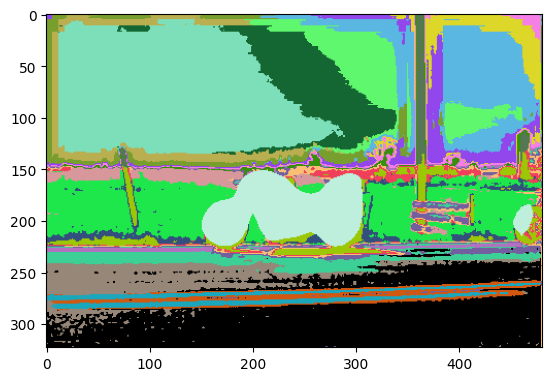

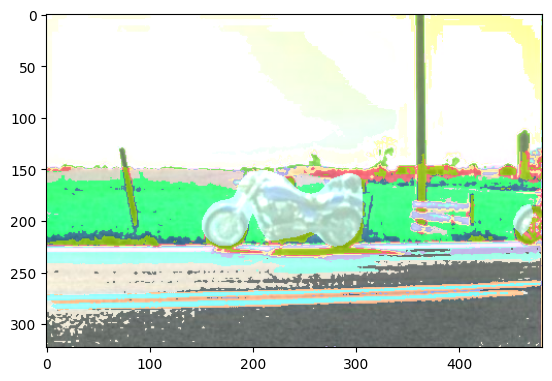

In [55]:
# Segmentation using Uniforce
options = {
		'algorithm': 'kmeans++', # clustering algorithm for initial overclustering from {'kmeans++', 'globalkmeans++'}
		'n_clusters': None, # number of desired clusters (default is None)
		'n_subclusters': 30, # number of overclustering clusters 
		'min_size': 10, # minimum subcluster size (required for statistical test validity)
		'distribution': 'default', # distribution to be tested for unimodality from {'default', 'pca'}
		'alpha': 1e-5, # confidence interval, max value 5e-2, 1e-2, 1e-3
		'n_tests': 11, # number of tests on subsampled clusters
		'max_iter': 1, # maximum number of overclustering iterations
	}
scaler = MinMaxScaler()
d2_new_pca_lab_sum_scaled = scaler.fit_transform(d2_new_pca_lab_sum)
uniforce = UniForCE(options)
uniforce.fit(d2_new_pca_lab_sum_scaled)
sublabels = uniforce.sublabels_
labels = uniforce.labels_

labels = labels.reshape((H, W))

unique_labels = np.unique(labels)
pca_lab_clusters = unique_labels.size
print("labels")
display(unique_labels)
print("sublabels")
unique_sublabels = np.unique(sublabels)
display(unique_sublabels)


colors = random_colors
def color_segmented_image():
	segmented_image = np.zeros((H, W, 3), dtype=np.uint8)
	for i, label in enumerate(unique_labels):
		mask = labels == label
		segmented_image[mask] = colors[i]
	return segmented_image

uniforce_segmented_image = color_segmented_image()
overlayed_image = image_overlay(input_image, uniforce_segmented_image)

plt.imshow(uniforce_segmented_image)
plt.show()
plt.imshow(overlayed_image[:, :, ::-1])
plt.show()

labels


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22])

sublabels


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

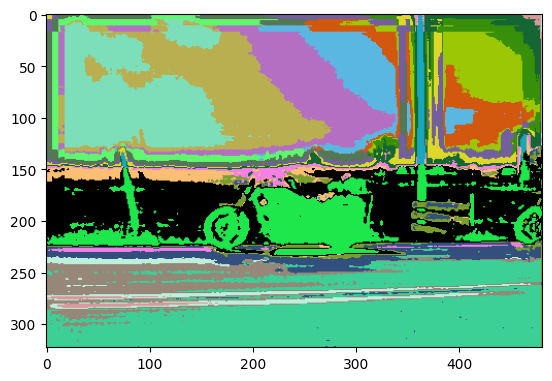

In [56]:
# Uniforce on pca deeplab features
options = {
		'algorithm': 'kmeans++', # clustering algorithm for initial overclustering from {'kmeans++', 'globalkmeans++'}
		'n_clusters': None, # number of desired clusters (default is None)
		'n_subclusters': 30, # number of overclustering clusters
		'min_size': 10, # minimum subcluster size (required for statistical test validity)
		'distribution': 'default', # distribution to be tested for unimodality from {'default', 'pca'}
		'alpha': 1e-5, # confidence interval, max value 5e-2, 1e-2, 1e-3
		'n_tests': 11, # number of tests on subsampled clusters
		'max_iter': 1, # maximum number of overclustering iterations
	}
scaler = MinMaxScaler()
pca_features_scaled = scaler.fit_transform(pca_features.reshape(n_components, pca_features.shape[1] * pca_features.shape[2]).T)
uniforce = UniForCE(options)
uniforce.fit(pca_features_scaled)
sublabels = uniforce.sublabels_
labels = uniforce.labels_

labels = labels.reshape((H, W))
unique_labels = np.unique(labels)
pca_clusters = unique_labels.size
print("labels")
display(unique_labels)
print("sublabels")
unique_sublabels = np.unique(sublabels)
display(unique_sublabels)

uniforce_pca_segmented_image = color_segmented_image()
overlayed_image = image_overlay(input_image, uniforce_pca_segmented_image)

plt.imshow(uniforce_pca_segmented_image)
plt.show()

(323, 481)

array([0, 1, 2])

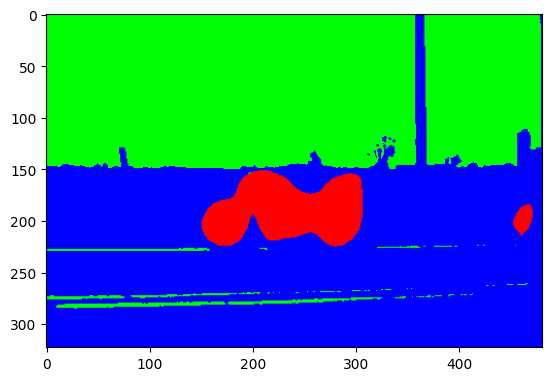

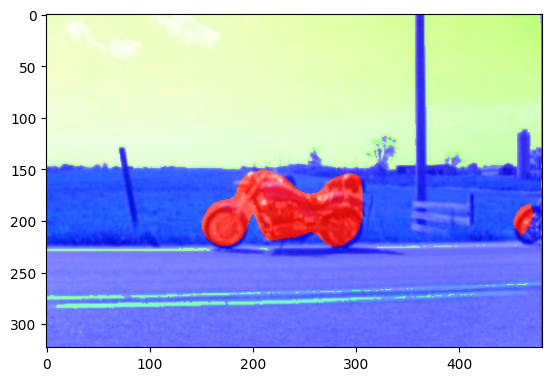

In [57]:
# ASPP features and LAB values K-Means
km = KMeans(n_clusters=best_k, n_init=10)
# x = pca_features.reshape(2, pca_features.shape[1] * pca_features.shape[2]).T # gia xrhsh mono pca features
km.fit(sampled_data)
labels = km.predict(d2_new_pca_lab_sum)

labels = labels.reshape((H, W))
display(labels.shape)

unique_labels = np.unique(labels)
display(unique_labels)

colors = [[255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 0], [255, 0, 255], [0, 255, 255]]

segmented_image = color_segmented_image()
overlayed_image = image_overlay(input_image, segmented_image)

plt.imshow(segmented_image)
plt.show()
plt.imshow(overlayed_image[:, :, ::-1])
plt.show()

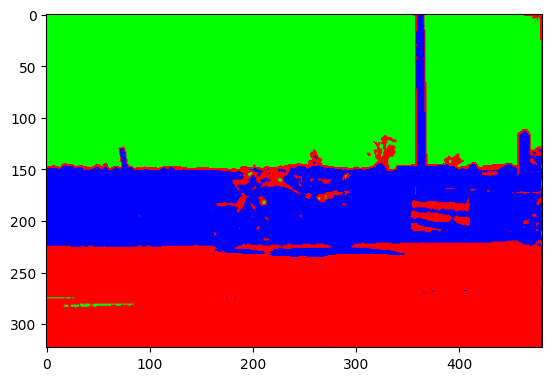

In [58]:
# Image segmentation using k-means on input rgb image
rgb_image = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
rgb_pixels = rgb_image.reshape((-1,3))

km = KMeans(n_clusters=best_k, n_init=10)
labels = km.fit_predict(rgb_pixels)

labels = labels.reshape((H, W))
unique_labels = np.unique(labels)

segmented_rgb_image = color_segmented_image()

plt.imshow(segmented_rgb_image)
plt.show()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21])

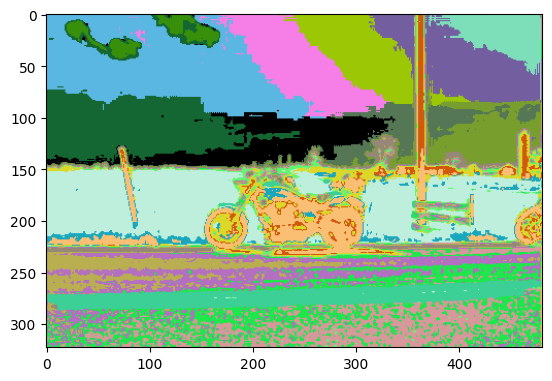

In [59]:
# Uniforce on input rgb image
options = {
		'algorithm': 'kmeans++', # clustering algorithm for initial overclustering from {'kmeans++', 'globalkmeans++'}
		'n_clusters': None, # number of desired clusters (default is None)
		'n_subclusters': 30, # number of overclustering clusters
		'min_size': 10, # minimum subcluster size (required for statistical test validity)
		'distribution': 'default', # distribution to be tested for unimodality from {'default', 'pca'}
		'alpha': 1e-5, # confidence interval, max value 5e-2, 1e-2, 1e-3
		'n_tests': 11, # number of tests on subsampled clusters
		'max_iter': 1, # maximum number of overclustering iterations
	}
scaler = MinMaxScaler()
rgb_pixels_scaled = scaler.fit_transform(rgb_pixels)
uniforce = UniForCE(options)
uniforce.fit(rgb_pixels_scaled)
labels = uniforce.labels_

labels = labels.reshape((H, W))
unique_labels = np.unique(labels)
rgb_clusters = unique_labels.size
display(unique_labels)

colors = random_colors
uniforce_rgb_image = color_segmented_image()

plt.imshow(uniforce_rgb_image)
plt.show()

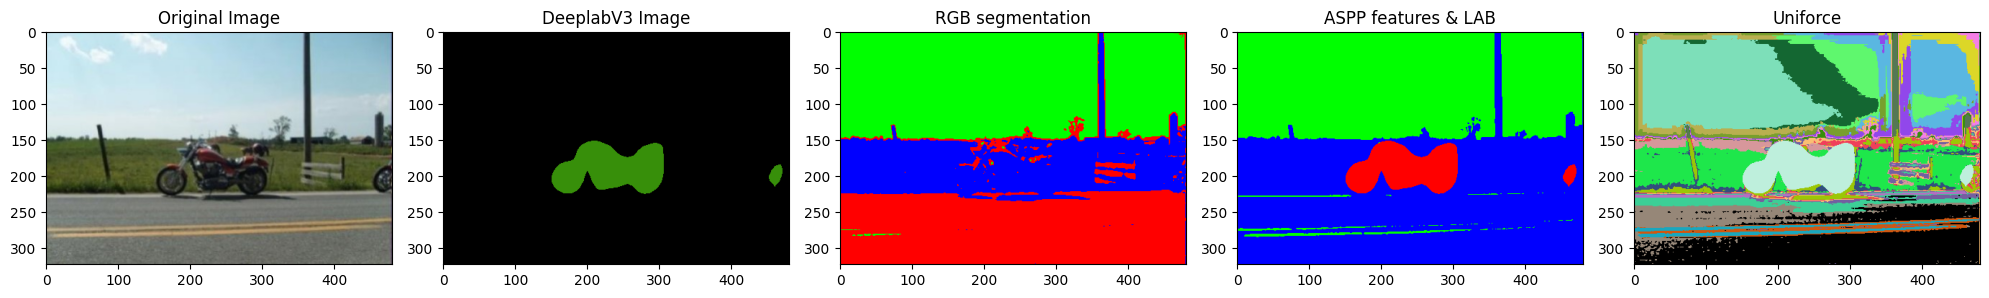

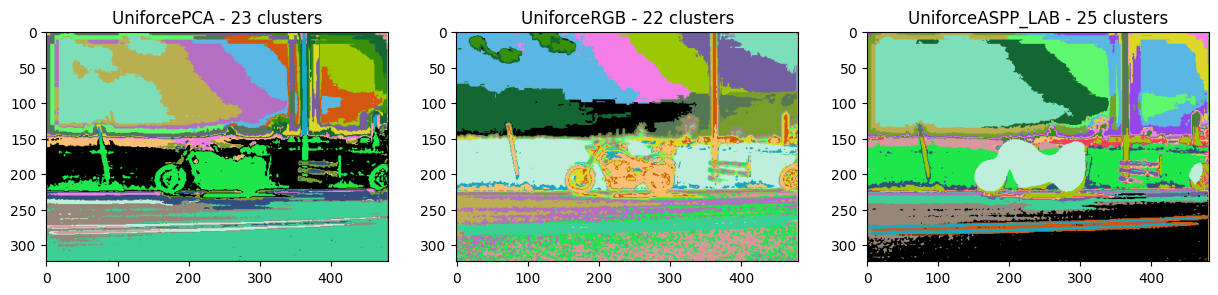

In [60]:
def display_images():
    _, axes = plt.subplots(1, 5, figsize=(20, 3))  
    
    axes[0].set_title("Original Image")
    axes[0].imshow(input_image)
    
    axes[1].set_title("DeeplabV3 Image")
    axes[1].imshow(deeplab_segmented_image)
    
    axes[2].set_title("RGB segmentation")
    axes[2].imshow(segmented_rgb_image)
    
    axes[3].set_title("ASPP features & LAB")
    axes[3].imshow(segmented_image)
    
    axes[4].set_title("Uniforce")
    axes[4].imshow(uniforce_segmented_image)
    
    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()

display_images()

plt.subplots(1, 3, figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("UniforcePCA - {} clusters".format(pca_clusters))
plt.imshow(uniforce_pca_segmented_image)
plt.subplot(1, 3, 2)
plt.title("UniforceRGB - {} clusters".format(rgb_clusters))
plt.imshow(uniforce_rgb_image)
plt.subplot(1, 3, 3)
plt.title("UniforceASPP_LAB - {} clusters".format(pca_lab_clusters))
plt.imshow(uniforce_segmented_image)
plt.show()